# Importing libraries and scripts

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import warnings

warnings.filterwarnings('ignore')
sys.path.append('..')

from scripts import dataframe as dfr
from scripts import matrix as mx
from scripts import regression as rgr
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

from collections import Counter

# Reading the data and training the model

In [20]:
df = pd.read_csv('../week_3/churn_data.csv')

df = dfr.data_frame_refining(df)

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

df_full_train,df_test = train_test_split(df,test_size=0.2,random_state=1)
df_train,df_val = train_test_split(df_full_train,test_size=0.25,random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

numerical_cols = ['tenure', 'monthlycharges', 'totalcharges']
categorical_cols = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [21]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_cols + numerical_cols].to_dict(orient='records')
val_dict = df_val[categorical_cols + numerical_cols].to_dict(orient='records')

In [22]:
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

In [23]:
model = LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression()

In [24]:
y_pred = model.predict_proba(X_val)[:,1]
churn_decision = y_pred >= 0.5

(y_val == churn_decision).mean()

0.8034066713981547

# Accuracy and dummy model

In [27]:
(y_val == churn_decision).sum()

1132

In [35]:
thresholds = np.linspace(0,1,21)

scores = []

for threshold in thresholds:
    churn_decision = y_pred >= threshold

    # score = (y_val == churn_decision).mean()
    score = accuracy_score(y_val,churn_decision)

    print('%.2f %.3f' %(threshold,score))

    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


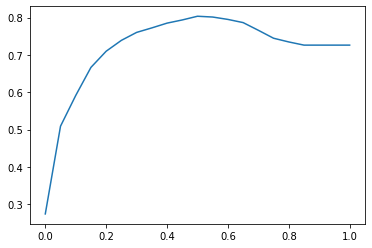

In [36]:
plt.plot(thresholds,scores)

# Confusion matrix

In [40]:
actual_positive = y_val == 1
actual_negative = y_val == 0

predict_positive = y_pred >= 0.5
predict_negative = y_pred < 0.5

In [41]:
tp = (actual_positive & predict_positive).sum()
tn = (actual_negative & predict_negative).sum()

In [42]:
tn , tp

(922, 210)

In [43]:
fn = (predict_negative & actual_positive).sum()
fp = (predict_positive & actual_negative).sum()

In [44]:
fn, fp

(176, 101)

In [54]:
confusion_mx = np.array([
    [tn,fp],
    [fn,tp]
])

confusion_mx

array([[922, 101],
       [176, 210]])

In [53]:
churn_decision = y_pred >= 0.5
confusion_matrix(y_val,churn_decision)

array([[922, 101],
       [176, 210]])

# Precision and Recall

In [55]:
accuracy = ( tn + tp ) / ( tn + tp + fp + fn )
accuracy

0.8034066713981547

In [58]:
precision = tp / (tp + fp )
precision.round(3)

0.675

In [60]:
recall = tp / ( tp + fn )
recall.round(3)

0.544